In [1]:
"""
Dataset Download
"""
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:00<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [2]:
"""
Process Data into a file
"""
import pandas as pd

file_path = f"{path}/creditcard.csv"
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
"""
Split into test & train + min-max scale
"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
"""
Obtain normal & anomalous sets (already scaled!)
Fraud = 1
"""
X_train_normal = X_train[y_train == 0]
X_train_anomalous = X_train[y_train == 1]

y_train_normal = y_train[y_train == 0]
y_train_anomalous = y_train[y_train == 1]

X_test_normal = X_test[y_test == 0]
X_test_anomalous = X_test[y_test == 1]

y_test_normal = y_test[y_test == 0]
y_test_anomalous = y_test[y_test == 1]

print(len(X_train_normal), len(y_train_normal), "and", type(X_train_normal))
print(len(X_train_anomalous), len(y_train_anomalous), "and", type(X_train_anomalous))

227451 227451 and <class 'numpy.ndarray'>
394 394 and <class 'numpy.ndarray'>


We will now use an Autoencoder built using TensorFlow for anomaly detection on the credit card dataset.

It will be trained to reconstruct the normal data as accurately as possible.

Then, when we pass in the anomalous transaction data, it will not reconstruct equally, hence deviating from the pattern.

Credits go to the TensorFlow [autoencoder guide](https://www.tensorflow.org/tutorials/generative/autoencoder#third_example_anomaly_detection), from which I learned some good practice on building TensorFlow models and the wide variety of applications of autoencoders and anomaly detection.

In [144]:
"""
Autoencoder Structure
"""
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

class AnomalyDetector(Model):
  def __init__(self, input_size, output_size):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(input_size, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(output_size, activation="sigmoid")])

  def call(self, x): # needs to be called `call`
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [147]:
"""
Training Autoencoder
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score

print("input", X_train.shape[1], "output", X_train.shape[1])
autoencoder = AnomalyDetector(X_train.shape[1], X_train.shape[1])

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train_normal, X_train_normal,
          epochs=10,
          batch_size=512,
          validation_data=(X_test_normal, X_test_normal),
          shuffle=True)

input 30 output 30
Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0136 - val_loss: 0.0016
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0010 - val_loss: 9.9319e-04
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.7778e-04 - val_loss: 8.6383e-04
Epoch 8/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.5002e-04 - val_loss: 8.2972e-04
Epoch 9/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.2242e-04 - val_loss: 8.1591e-04
Epoch 10/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.0973e-04 - val_loss: 8.0129e-04


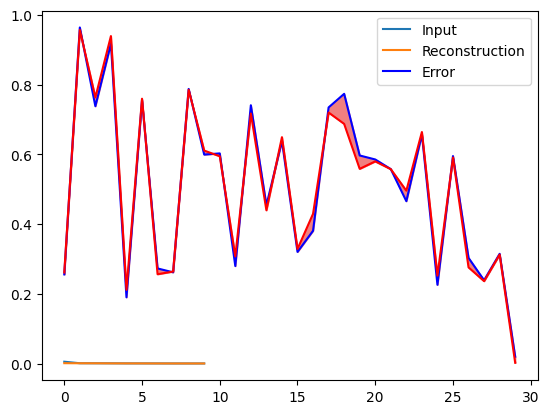

In [148]:
"""
Loss history plotting on normal data - error expected to be small
"""
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.legend()

encoded_data = autoencoder.encoder(X_test_normal).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(X_test_normal[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(30), decoded_data[0], X_test_normal[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

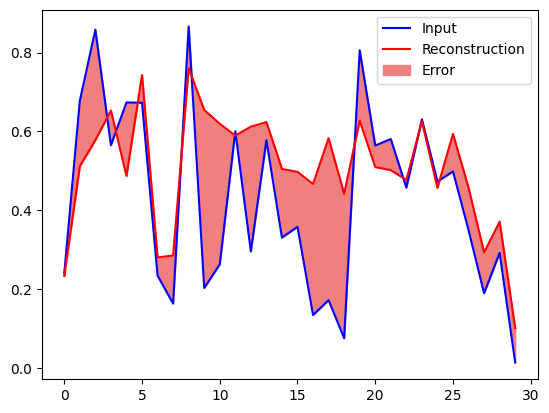

In [149]:
"""
Reconstruction error of anomalous samples
Expect error to be large
"""
encoded_data = autoencoder.encoder(X_test_anomalous).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(X_test_anomalous[0], 'b') # blue is original data (At first dimension)
plt.plot(decoded_data[0], 'r') # red is reconstructed data
plt.fill_between(np.arange(30), decoded_data[0], X_test_anomalous[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


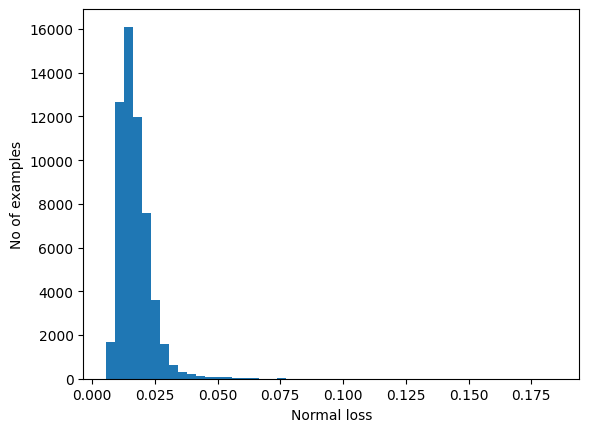

Threshold:  0.027759759650028637


In [153]:
"""
Measuring the model's anomaly detection abilities
"""
reconstructions = autoencoder.predict(X_test_normal)
normal_loss = tf.keras.losses.mae(reconstructions, X_test_normal)
plt.hist(normal_loss[None,:], bins=50)
plt.xlabel("Normal loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.percentile(normal_loss, 95)
print("Threshold: ", threshold)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


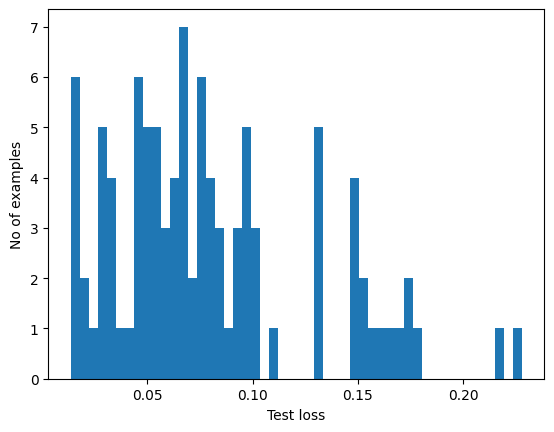

In [154]:
"""
On anomalous data -
"""
reconstructions = autoencoder.predict(X_test_anomalous)
test_loss = tf.keras.losses.mae(reconstructions, X_test_anomalous)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, X_test, threshold)
print_stats(preds, y_test)

Accuracy = 0.05012113338717039
Precision = 0.0002035868297829024
Recall = 0.11224489795918367


In [162]:
from sklearn.utils import resample

# Separate normal and anomaly data
X_train_normal, X_train_anomalies = X_train[y_train == 0], X_train[y_train == 1]

# Up-sample anomalies to match normal data
X_train_anomalies_upsampled = resample(X_train_anomalies,
                                       replace=True,  # Resample with replacement
                                       n_samples=X_train_normal.shape[0],  # Match number of normal samples
                                       random_state=42)

# Combine the resampled anomalies with the normal data
X_train_resampled = np.vstack([X_train_normal, X_train_anomalies_upsampled])
y_train_resampled = np.hstack([np.zeros(X_train_normal.shape[0]), np.ones(X_train_anomalies_upsampled.shape[0])])

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
AUC Score:  0.6796372458892759


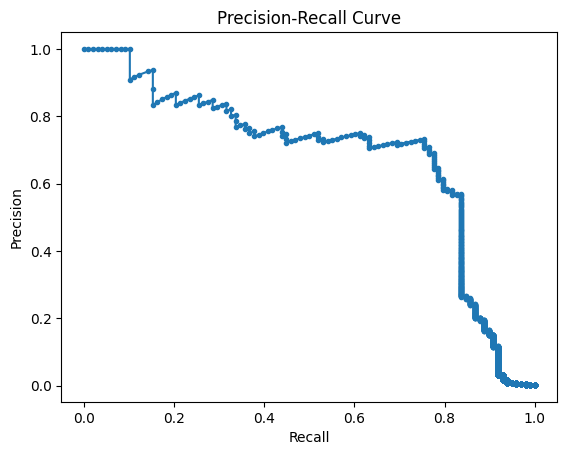

Accuracy: 0.9991
Precision: 0.7300
Recall: 0.7449
F1 Score: 0.7374


In [160]:
"""
Pivoting to hybrid logistic regression
"""
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve, auc

reconstruction_error = np.abs(X_train_resampled - autoencoder.predict(X_train_resampled))
clf = LogisticRegression()
clf.fit(reconstruction_error, y_train_resampled)

reconstruction_error_test = np.abs(X_test - autoencoder.predict(X_test))

y_pred_prob = clf.predict_proba(reconstruction_error_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_best_threshold = (y_pred_prob > best_threshold).astype(int)

auc_score = auc(recall, precision)
print("AUC Score: ", auc_score)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Evaluate using standard classification metrics
accuracy = accuracy_score(y_test, y_pred_best_threshold)
precision = precision_score(y_test, y_pred_best_threshold)
recall = recall_score(y_test, y_pred_best_threshold)
f1 = f1_score(y_test, y_pred_best_threshold)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")